## Проект от DonorSearch - Кластеризация пользователей
подготовил Дитятев Иван 
tg - @ivdit

#### Цель:
 Разделить пользователей на кластеры. 
 
 Предлагаемые кластеры: 
 - активный донор, 
 - спящий донор, 
 - реактивированный донор, 
 - потерянный.

#### Задачи:
- Предобработка данных.
- Определение оптимального числа кластеров.
- Разделение пользователей на кластеры.
- Определение четких правил, как отнести пользователя к тому или иному кластеру.
- Исследовательский анализ данных.
- Создание презентации.


In [1]:
from typing import Dict, Optional, Tuple, List
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
import warnings


warnings.filterwarnings('ignore')


In [2]:
today = datetime.today()


def to_datetime(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Переводим во временной формат список колонок."""
    for column in columns:
      if column not in frozenset(df.columns):
        raise ValueError(f'Column {column} not in dataframe')
      df[column] = pd.to_datetime(df[column], format='%d.%m.%Y',  errors='coerce')
    return df


def to_int(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """Переводим в int формат список колонок."""
    for column in columns:
      if column not in frozenset(df.columns):
        raise ValueError(f'Column {column} not in dataframe')
      df[column] = df[column].astype(int, errors='ignore')
    return df


def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Удаляем дубликаты."""
    return df.drop_duplicates()


def remove_columns(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Удаляет указанные колонки из DataFrame.
    """
    return df.drop(columns=columns)


def apply_dbscan_in_batches(X: List[List[float]], batch_size: int, eps: float, min_samples: int) -> List[int]:
    """Разбиваем выборку на части и объединяем результат."""
    labels = np.full(X.shape[0], -1)
    for i in range(0, X.shape[0], batch_size):
        batch = X[i:i + batch_size]
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        batch_labels = dbscan.fit_predict(batch)
        labels[i:i + batch_size] = batch_labels
    return labels


def t_test_with_bonferroni(df: pd.DataFrame, column: str) -> Dict[str, Dict[str, float]]:
    """Тест Стьюдента с поправкой Бонферонни и проверкой нормальности распределения."""
    clusters = df['Кластер'].unique()
    results = {}
    num_tests = len(clusters) * (len(clusters) - 1) / 2
    alpha = 0.05 / num_tests
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            cluster1 = df[df['Кластер'] == clusters[i]][column].dropna()
            cluster2 = df[df['Кластер'] == clusters[j]][column].dropna()
            shapiro_cluster1 = stats.shapiro(cluster1)
            shapiro_cluster2 = stats.shapiro(cluster2)
            if shapiro_cluster1.pvalue > 0.05 and shapiro_cluster2.pvalue > 0.05:
                t_stat, p_value = stats.ttest_ind(cluster1, cluster2, nan_policy='omit')
            else:
                t_stat, p_value = stats.mannwhitneyu(cluster1, cluster2, alternative='two-sided')
            results[f'{clusters[i]} vs {clusters[j]}'] = {'stat': t_stat, 'p_value': p_value, 'significant': p_value < alpha}
    return results


def chi_square_test(data: pd.DataFrame, column: str) -> Tuple[float]:
    """Хи-квадрат тест."""
    contingency_table = pd.crosstab(data[column], data['Кластер'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p


def calculate_age(birthdate: Optional[pd.Timestamp]) -> Optional[int]:
    """Вычисляет возраст на основе даты рождения."""
    if pd.isnull(birthdate) or birthdate is pd.NaT:
        return None
    birthdate = pd.to_datetime(birthdate)
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age


def days_since_last_activity(last_activity_date: Optional[pd.Timestamp]) -> Optional[int]:
    """Вычисляет количество дней, прошедших с последней активности."""
    if pd.isnull(last_activity_date) or last_activity_date is pd.NaT:
        return None
    last_activity_date = pd.to_datetime(last_activity_date)
    days_passed = (today - last_activity_date).days
    return days_passed


def elbow_method(data: pd.DataFrame) -> None:
    """Метод локтя."""
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Искажение')
    plt.title('Метод "локтя" для определения оптимального количества кластеров')
    plt.show()


def analyze_numeric_columns(df: pd.DataFrame, numeric_columns: List[str]) -> None:
    """Построение графиков для числовых колонок."""
    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Кластер', y=column, data=df)
        plt.title(f'Boxplot для {column} по кластерам')
        plt.show()


def analyze_categorical_columns(df: pd.DataFrame, categorical_columns: List[str]) -> None:
    """Построение графиков для категориальных колонок."""
    for column in set(categorical_columns) - set(['Регион']):
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Кластер', hue=column, data=df)
        plt.title(f'Столбчатая диаграмма для {column} по кластерам')
        plt.show()

In [3]:
# table User
user_data = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/users_anon_data.csv')
user_data = to_datetime(user_data, ['Дата регистрации', 'Дата рождения', 'Отвод от донации', 'Последняя активность'])
user_data = to_int(user_data, ['Донаций на момент регистрации', 'Донаций до регистрации'])
user_data = remove_duplicates(user_data)
user_data = remove_columns(user_data, ['Почетный донор', 'Получен значок 20', 'Получен значок 75', 'Получен значок 100', 'Получен значок 150', 'Получен значок друг DS', 'Отправлена футболка', 'Отправлен браслет', 'Донаций с 1 января'])
user_data['Возраст'] = user_data['Дата рождения'].apply(calculate_age)
user_data['Дни с последней активности'] = user_data['Последняя активность'].apply(days_since_last_activity)
display(user_data.head())
user_data.info()
user_data.describe()


# table User_Bonus
user_bonus = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/user_bonus_anon.csv')
display(user_bonus.head())


# table Donation
donations = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/donations_anon.csv')
donations = to_datetime(donations, ['Дата донации', 'Дата планирования', 'Дата добавления донации'])
donations = donations.drop_duplicates()
donations = donations[donations['Есть справка'] == 'Да']
donations.info()
display(donations.describe())
display(donations.head())
display(donations['Статус донации'].unique())
display(donations['Есть справка'].value_counts())
df = donations.groupby(by='ID пользователя', as_index=False).agg({'Дата донации': lambda x: x.diff().dt.days.abs().mean(), 'ID': 'count'}).rename(columns={'Дата донации':'Средний интервал между донациями', 'ID': 'Количество донаций'}).fillna(0)
df = df.merge(user_data[['ID', 'Дни с последней активности']], left_on='ID пользователя', right_on='ID', how='left')
df['Дни с последней активности'] = df['Дни с последней активности'].fillna(1500)
df = df.drop(columns=['ID'])
df = df.set_index('ID пользователя')
display(df.head())
df.info()
display(df.describe())


# table Plan_Donation
donations_plan = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/anon_donations_plan.csv')
display(donations_plan.head())


# table Bonuse
bonuses = pd.read_csv('C:/Dev/donorsearch/donorsearch_test/DonorSearch2024/bonuses_anon.csv')
bonuses.head()

ID         Пол Дата рождения                           Регион  \
0  300328  Не указано           NaT  Россия, Тверская область, Тверь   
1  300327     Мужской    1971-12-08                       Не указано   
2  300326  Не указано           NaT                   Россия, Москва   
3  300325  Не указано           NaT                       Не указано   
4  300324     Мужской    1971-10-12                       Не указано   

  Группа крови Kell-фактор Готов сдавать Цельную кровь Готов сдавать Плазму  \
0   Не указано  Не указано                          Да                   Да   
1   Не указано  Не указано                          Да                   Да   
2   Не указано  Не указано                          Да                   Да   
3   Не указано  Не указано                          Да                   Да   
4   Не указано  Не указано                          Да                   Да   

  Готов сдавать Тромбоциты Готов сдавать Эритроциты  ... Авторизация через ВК  \
0                       Да                       Да  ...                   да   
1                       Да                       Да  ...                  нет   
2                       Да                       Да  ...                  нет   
3                       Да                       Да  ...                  нет   
4                       Да                       Да  ...                  нет   

  Авторизация через Одноклассники Авторизация через Твиттер  \
0                             нет                       нет   
1                             нет                       нет   
2                             нет                       нет   
3                             нет                       нет   
4                             нет                       нет   

   Авторизация через Яндекс  Авторизация через Гугл  Подтверждённые донации  \
0                       нет                     нет                       0   
1                       нет                     нет                       0   
2                       нет                     нет                       0   
3                       нет                     нет                       0   
4                       нет                     нет                       0   

   Донаций на момент регистрации  Количество взятых бонусов Возраст  \
0                     Не указано                          0     NaN   
1                     Не указано                          0    52.0   
2                     Не указано                          0     NaN   
3                     Не указано                          0     NaN   
4                     Не указано                          0    52.0   

   Дни с последней активности  
0                        32.0  
1                         NaN  
2                        32.0  
3                        32.0  
4                         NaN  

[5 rows x 36 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286913 entries, 0 to 286912
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   ID                               286913 non-null  int64         
 1   Пол                              286913 non-null  object        
 2   Дата рождения                    107507 non-null  datetime64[ns]
 3   Регион                           286913 non-null  object        
 4   Группа крови                     286913 non-null  object        
 5   Kell-фактор                      286913 non-null  object        
 6   Готов сдавать Цельную кровь      286913 non-null  object        
 7   Готов сдавать Плазму             286913 non-null  object        
 8   Готов сдавать Тромбоциты         286913 non-null  object        
 9   Готов сдавать Эритроциты         286913 non-null  object        
 10  Готов сдавать Лейкоциты          286913 non-

ID пользователя  Количество взятых бонусов  Количество донаций  \
0           149473                        121                  61   
1           275997                          7                   2   
2           182830                         11                  22   
3           174938                          2                  32   
4           279206                          4                  13   

      Название партнера                                          Бонус  \
0  Череповецкий марафон  Скидка 10% на участие в Череповецком марафоне   
1           DonorSearch     10% на мерч от DonorSearch в ЯндексМаркете   
2           DonorSearch     10% на мерч от DonorSearch в ЯндексМаркете   
3           DonorSearch     10% на мерч от DonorSearch в ЯндексМаркете   
4           DonorSearch     10% на мерч от DonorSearch в ЯндексМаркете   

  Дата использования  Страна              Регион            Город  
0         15.08.2024  Россия                 NaN  Санкт-Петербург  
1         25.08.2024  Россия  Ивановская область          Иваново  
2         25.08.2024  Россия                 NaN  Санкт-Петербург  
3         25.08.2024  Россия     Томская область            Томск  
4         24.08.2024  Россия                 NaN           Москва

<class 'pandas.core.frame.DataFrame'>
Index: 335659 entries, 0 to 356829
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID                       335659 non-null  int64         
 1   ID пользователя          335659 non-null  int64         
 2   Класс крови              335659 non-null  object        
 3   Дата донации             335659 non-null  datetime64[ns]
 4   Дата планирования        16316 non-null   datetime64[ns]
 5   Тип донации              335659 non-null  object        
 6   Город                    335659 non-null  object        
 7   Регион                   335659 non-null  object        
 8   Страна                   335659 non-null  object        
 9   Место сдачи              335659 non-null  object        
 10  Есть справка             335659 non-null  object        
 11  Дата добавления донации  335659 non-null  datetime64[ns]
 12  Статус донации       

ID  ID пользователя                   Дата донации  \
count  335659.000000    335659.000000                         335659   
mean   184477.115412    179182.734707  2018-04-26 01:35:42.427880960   
min         1.000000         4.000000            1975-01-01 00:00:00   
25%     88393.500000    127473.500000            2015-04-24 00:00:00   
50%    185482.000000    195840.000000            2019-03-05 00:00:00   
75%    279547.500000    256432.000000            2022-08-11 00:00:00   
max    367797.000000    300322.000000            2098-07-02 00:00:00   
std    107772.301210     89032.066151                            NaN   

                   Дата планирования        Дата добавления донации  
count                          16316                         335659  
mean   2023-03-19 02:38:41.157146880  2022-11-04 03:48:02.571896064  
min              2020-11-20 00:00:00            2020-11-18 00:00:00  
25%              2022-08-23 00:00:00            2020-11-18 00:00:00  
50%              2023-04-13 00:00:00            2023-02-14 00:00:00  
75%              2023-12-02 00:00:00            2024-02-05 00:00:00  
max              2024-10-07 00:00:00            2024-08-25 00:00:00  
std                              NaN                            NaN

ID  ID пользователя    Класс крови Дата донации Дата планирования  \
0  367797           210974  Цельная кровь   2023-11-22               NaT   
1  367796           146460         Плазма   2024-08-16        2024-08-16   
2  367795           292587  Цельная кровь   2024-08-24        2024-08-24   
3  367794           300322  Цельная кровь   2024-08-23               NaT   
4  367793           300322  Цельная кровь   2024-05-07               NaT   

    Тип донации     Город                Регион  Страна  \
0  Безвозмездно  Оренбург  Оренбургская область  Россия   
1  Безвозмездно   Рыбинск   Ярославская область  Россия   
2  Безвозмездно    Москва             Не указан  Россия   
3  Безвозмездно       Уфа          Башкортостан  Россия   
4  Безвозмездно       Уфа          Башкортостан  Россия   

                                         Место сдачи Есть справка  \
0  ГБУЗ "Оренбургская областная станция переливан...           Да   
1      ГБУЗ ЯО "Рыбинская станция переливания крови"           Да   
2       Центр крови им. Гаврилова (центр в Царицыно)           Да   
3   ГБУЗ "Республиканская станция переливания крови"           Да   
4   ГБУЗ "Республиканская станция переливания крови"           Да   

  Дата добавления донации Статус донации  
0              2024-08-25   На модерации  
1              2024-08-25   На модерации  
2              2024-08-25   На модерации  
3              2024-08-25   На модерации  
4              2024-08-25   На модерации

array(['На модерации', 'Принята', 'Удалена', 'Отклонена',
       'На модерации после принятия', 'Без справки'], dtype=object)

Есть справка
Да    335659
Name: count, dtype: int64

Средний интервал между донациями  Количество донаций  \
ID пользователя                                                         
4                                        0.000000                   1   
7                                        0.000000                   1   
8                                       63.000000                   3   
11                                     376.250000                   5   
14                                     150.384615                  14   

                 Дни с последней активности  
ID пользователя                              
4                                    1500.0  
7                                    1500.0  
8                                    1500.0  
11                                     98.0  
14                                   1321.0

<class 'pandas.core.frame.DataFrame'>
Index: 47134 entries, 4 to 300322
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Средний интервал между донациями  47134 non-null  float64
 1   Количество донаций                47134 non-null  int64  
 2   Дни с последней активности        47134 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.4 MB


Средний интервал между донациями  Количество донаций  \
count                      47134.000000        47134.000000   
mean                         140.192929            7.121377   
std                          308.063561           15.118167   
min                            0.000000            1.000000   
25%                            0.000000            1.000000   
50%                           38.500000            2.000000   
75%                          167.666667            5.000000   
max                         8898.000000          378.000000   

       Дни с последней активности  
count                47134.000000  
mean                   839.292167  
std                    612.763058  
min                     32.000000  
25%                    183.000000  
50%                    752.000000  
75%                   1500.000000  
max                   1500.000000

ID  ID пользователя    Класс крови Планируемая дата  \
0  38294           223833         Плазма       16.09.2024   
1  38293           300325  Цельная кровь       29.08.2024   
2  38292           300325  Цельная кровь       29.08.2024   
3  38291             6790  Цельная кровь       23.10.2024   
4  38290             6790  Цельная кровь       23.10.2024   

  Дата создания планирования   Тип донации  \
0                 25.08.2024  Безвозмездно   
1                 25.08.2024  Безвозмездно   
2                 25.08.2024  Безвозмездно   
3                 25.08.2024  Безвозмездно   
4                 25.08.2024  Безвозмездно   

                                  Регион  \
0                         Россия, Москва   
1                Россия, Санкт-Петербург   
2   Россия, Воронежская область, Воронеж   
3  Россия, Кемеровская область, Кемерово   
4  Россия, Кемеровская область, Кемерово   

                                        Место стадчи                 Статус  \
0                    НМИЦ ССХ им. А.Н. Бакулева, ОПК  донация запланирована   
1  Городская станция переливания крови Санкт-Пете...  донация запланирована   
2                      ГУЗ "Воронежская ОКБ №1", ОПК  планирование отменено   
3  МУЗ "ГКБ №3 им. М.А. Подгорбунского", отделени...  донация запланирована   
4  МУЗ "ГКБ №3 им. М.А. Подгорбунского", отделени...  донация запланирована   

  Есть справка  
0          Нет  
1          Нет  
2          Нет  
3          Нет  
4          Нет

ID Изображение бонуса Изображение партнера Опубликован?  \
0  208               Есть                 Есть          Нет   
1  207               Есть                 Есть           Да   
2  205               Есть                 Есть           Да   
3  204               Есть                 Есть           Да   
4  203               Есть                 Есть           Да   

  На главной странице?  Приоритет  Взято промокодов  Всего промокодов  \
0                  Нет          0                 1                25   
1                  Нет       1000                57               102   
2                  Нет          0                 2               100   
3                  Нет        100                54              1000   
4                  Нет        100                57              1000   

  Срок действия Дата добавления         Города  
0    24.08.2024      14.08.2024  Доступен всем  
1    31.08.2024      14.08.2024  Доступен всем  
2    31.08.2024      02.08.2024         Москва  
3    31.10.2024      24.07.2024  Доступен всем  
4    31.10.2024      24.07.2024  Доступен всем

$$WCSS =  \sum_{j=1}^k \sum_{i=1}^n \min(\|x^{(j)}_i - c_j\|^2)$$


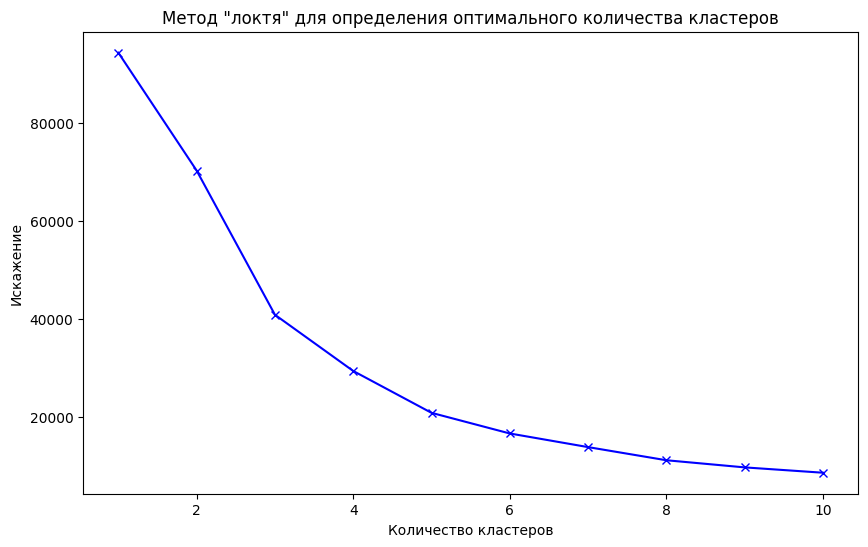

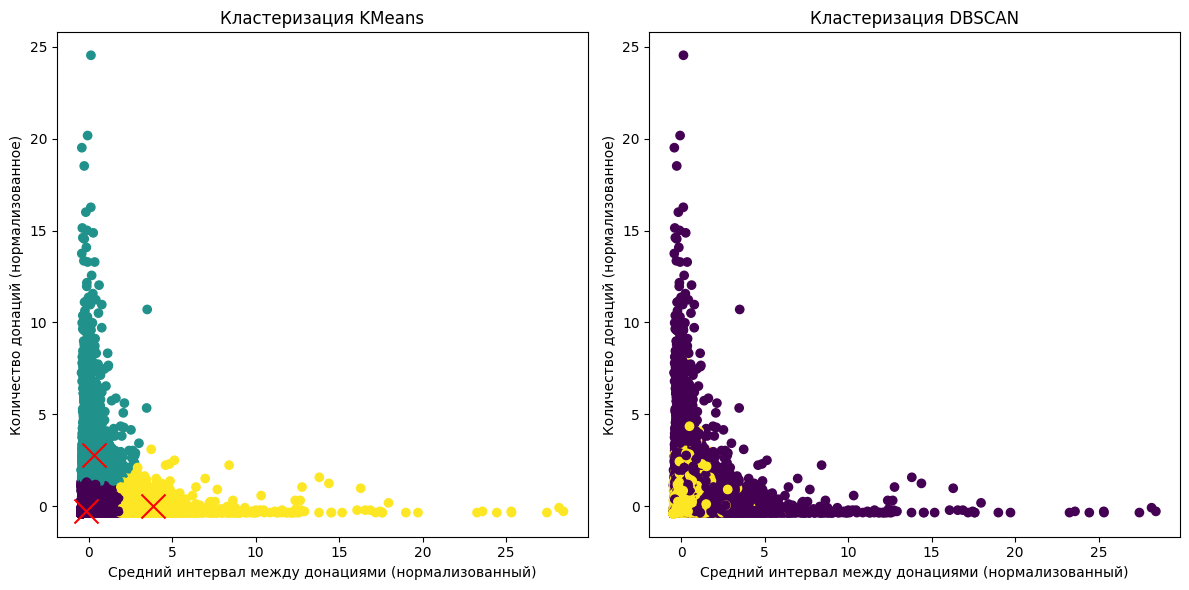

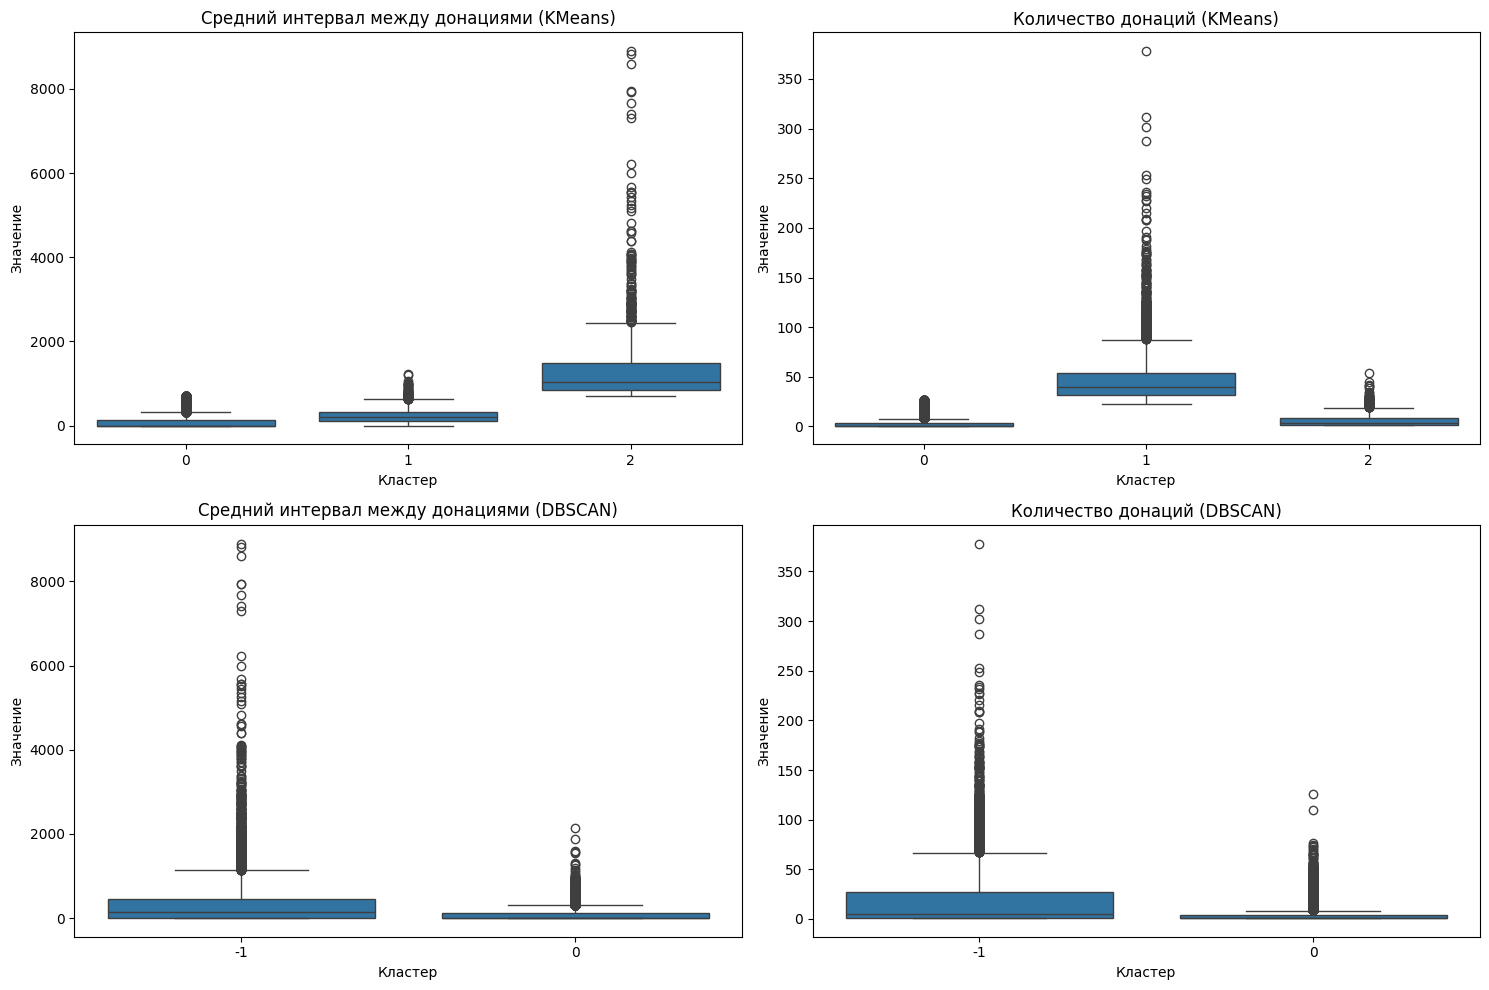

In [4]:
# Нормализация данных
scaler = StandardScaler()
X = df[['Средний интервал между донациями', 'Количество донаций']].values
X_scaled = scaler.fit_transform(X)


# Определение оптимального кол-ва кластеров
elbow_method(X_scaled)


# Кластеризация KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


# Визуализация KMeans
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.xlabel('Средний интервал между донациями (нормализованный)')
plt.ylabel('Количество донаций (нормализованное)')
plt.title('Кластеризация KMeans')


# Применение DBSCAN к мини-пакетам
batch_size = 2
dbscan_labels = apply_dbscan_in_batches(X_scaled, batch_size, eps=1.5, min_samples=2)

# Визуализация DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.xlabel('Средний интервал между донациями (нормализованный)')
plt.ylabel('Количество донаций (нормализованное)')
plt.title('Кластеризация DBSCAN')
plt.tight_layout()
plt.show()

# Добавление меток кластеров в DataFrame
df['Кластер_kmeans'] = kmeans_labels
df['Кластер_dbscan'] = dbscan_labels

# Преобразование данных в "long-form" формат для KMeans
df_melted_kmeans = pd.melt(df, id_vars=['Кластер_kmeans'], value_vars=['Средний интервал между донациями', 'Количество донаций'], var_name='Показатель', value_name='Значение')

# Преобразование данных в "long-form" формат для DBSCAN
df_melted_dbscan = pd.melt(df, id_vars=['Кластер_dbscan'], value_vars=['Средний интервал между донациями', 'Количество донаций'], var_name='Показатель', value_name='Значение')

# Создание фигуры с четырьмя подграфиками
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# График для "Средний интервал между донациями" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Средний интервал между донациями'], ax=axes[0, 0])
axes[0, 0].set_title('Средний интервал между донациями (KMeans)')
axes[0, 0].set_xlabel('Кластер')
axes[0, 0].set_ylabel('Значение')

# График для "Количество донаций" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Количество донаций'], ax=axes[0, 1])
axes[0, 1].set_title('Количество донаций (KMeans)')
axes[0, 1].set_xlabel('Кластер')
axes[0, 1].set_ylabel('Значение')

# График для "Средний интервал между донациями" (DBSCAN)
sns.boxplot(x='Кластер_dbscan', y='Значение', data=df_melted_dbscan[df_melted_dbscan['Показатель'] == 'Средний интервал между донациями'], ax=axes[1, 0])
axes[1, 0].set_title('Средний интервал между донациями (DBSCAN)')
axes[1, 0].set_xlabel('Кластер')
axes[1, 0].set_ylabel('Значение')

# График для "Количество донаций" (DBSCAN)
sns.boxplot(x='Кластер_dbscan', y='Значение', data=df_melted_dbscan[df_melted_dbscan['Показатель'] == 'Количество донаций'], ax=axes[1, 1])
axes[1, 1].set_title('Количество донаций (DBSCAN)')
axes[1, 1].set_xlabel('Кластер')
axes[1, 1].set_ylabel('Значение')
plt.tight_layout()
plt.show()

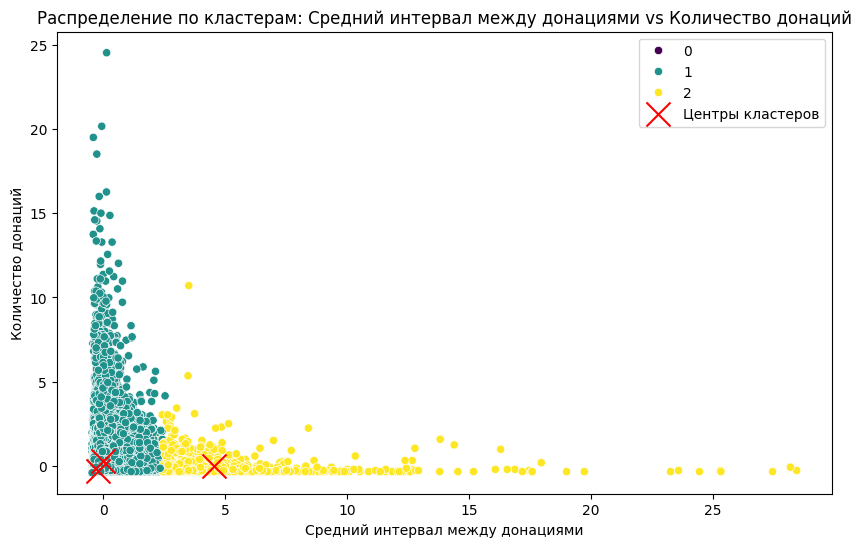

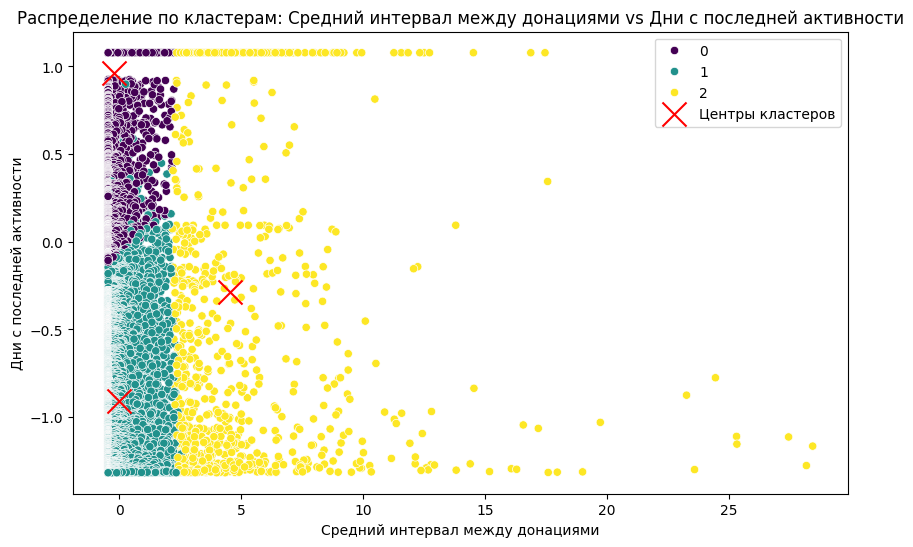

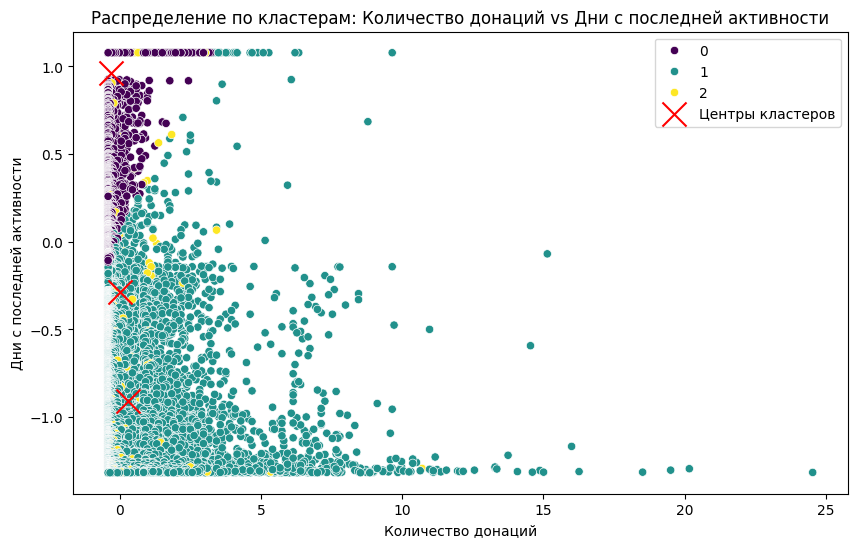

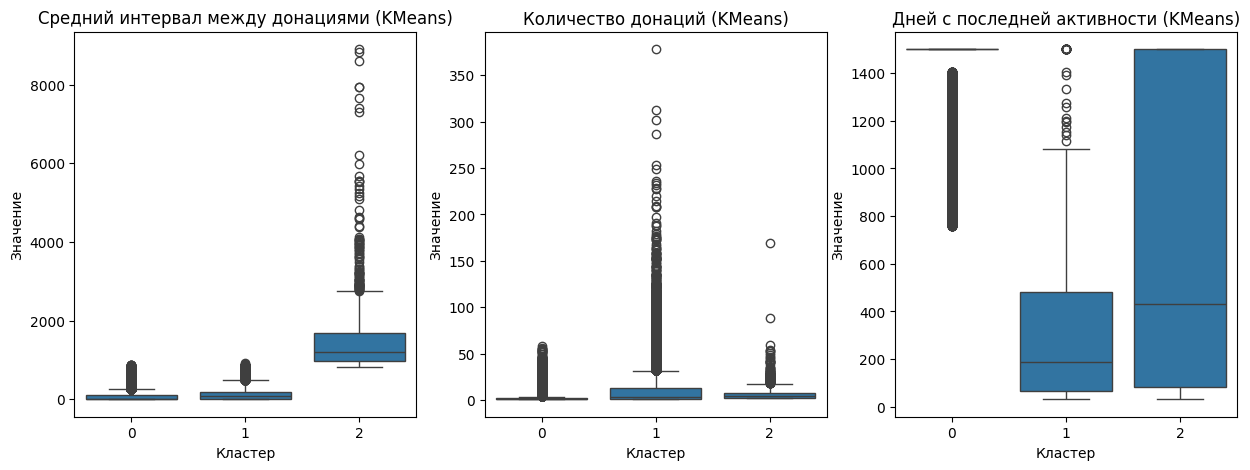

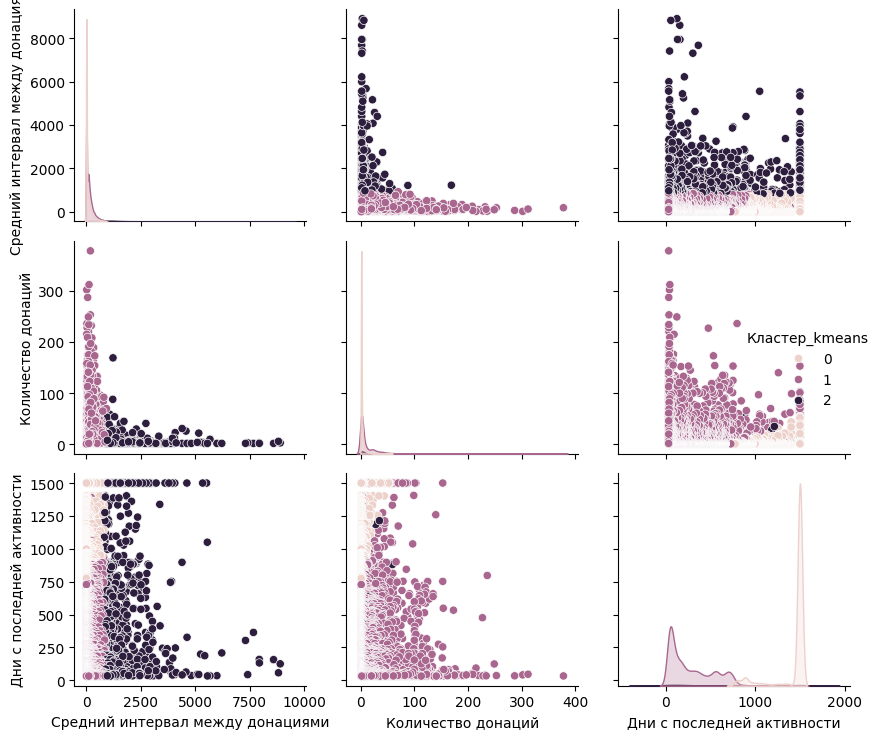

In [5]:
# Нормализация данных
scaler = StandardScaler()
X = df[['Средний интервал между донациями', 'Количество донаций', 'Дни с последней активности']].values
X_scaled = scaler.fit_transform(X)

# Кластеризация KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

# Добавление меток кластеров в DataFrame
df['Кластер_kmeans'] = kmeans_labels

# Создание 3D scatter plot с центрами кластеров
fig = px.scatter_3d(df, x='Средний интервал между донациями', y='Количество донаций', z='Дни с последней активности',
                    color='Кластер_kmeans', title='3D Scatter Plot по кластерам KMeans')
fig.add_scatter3d(x=cluster_centers[:, 0], y=cluster_centers[:, 1], z=cluster_centers[:, 2],
                  mode='markers', marker=dict(size=10, color='red', symbol='x'), name='Центры кластеров')
fig.show()

# Создание попарных проекций с центрами кластеров
features = ['Средний интервал между донациями', 'Количество донаций', 'Дни с последней активности']
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X_scaled[:, i], y=X_scaled[:, j], hue=kmeans_labels, palette='viridis')
        plt.scatter(cluster_centers[:, i], cluster_centers[:, j], s=300, c='red', marker='x', label='Центры кластеров')
        plt.xlabel(features[i])
        plt.ylabel(features[j])
        plt.title(f'Распределение по кластерам: {features[i]} vs {features[j]}')
        plt.legend()
        plt.show()


# Преобразование данных в "long-form" формат для KMeans
df_melted_kmeans = pd.melt(df, id_vars=['Кластер_kmeans'], value_vars=['Средний интервал между донациями', 'Количество донаций', 'Дни с последней активности'], var_name='Показатель', value_name='Значение')

# Создание фигуры с тремя подграфиками
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# График для "Средний интервал между донациями" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Средний интервал между донациями'], ax=axes[0])
axes[0].set_title('Средний интервал между донациями (KMeans)')
axes[0].set_xlabel('Кластер')
axes[0].set_ylabel('Значение')

# График для "Количество донаций" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Количество донаций'], ax=axes[1])
axes[1].set_title('Количество донаций (KMeans)')
axes[1].set_xlabel('Кластер')
axes[1].set_ylabel('Значение')

# График для "Дней с последней активности" (KMeans)
sns.boxplot(x='Кластер_kmeans', y='Значение', data=df_melted_kmeans[df_melted_kmeans['Показатель'] == 'Дни с последней активности'], ax=axes[2])
axes[2].set_title('Дней с последней активности (KMeans)')
axes[2].set_xlabel('Кластер')
axes[2].set_ylabel('Значение')

# Попарные сравнения признаков
sns.pairplot(df, hue='Кластер_kmeans', vars=['Средний интервал между донациями', 'Количество донаций', 'Дни с последней активности'])
plt.tight_layout()
plt.show()


In [6]:
# Определение четких правил соотнесения кластеров
grouped = df_melted_kmeans.groupby(by=['Кластер_kmeans', 'Показатель']).describe()
grouped[('Значение', 'lb')] = grouped[('Значение', '25%')] - 1.5 * (grouped[('Значение', '75%')] - grouped[('Значение', '25%')])
grouped[('Значение', 'ub')] = grouped[('Значение', '75%')] + 1.5 * (grouped[('Значение', '75%')] - grouped[('Значение', '25%')])
for column in [('Значение', 'ub'), ('Значение', 'lb')]:
    grouped[column] = grouped[column].apply(lambda x: x if x >=0 else 0)
display(grouped)

Значение               \
                                                   count         mean   
Кластер_kmeans Показатель                                               
0              Дни с последней активности        22531.0  1427.619546   
               Количество донаций                22531.0     2.627313   
               Средний интервал между донациями  22531.0    76.276041   
1              Дни с последней активности        23483.0   283.141549   
               Количество донаций                23483.0    11.418643   
               Средний интервал между донациями  23483.0   134.532684   
2              Дни с последней активности         1120.0   664.721429   
               Количество донаций                 1120.0     7.427679   
               Средний интервал между донациями   1120.0  1544.684856   

                                                                     \
                                                        std     min   
Кластер_kmeans Показатель                                             
0              Дни с последней активности        190.176261  759.00   
               Количество донаций                  4.171850    1.00   
               Средний интервал между донациями  142.640807    0.00   
1              Дни с последней активности        242.352454   32.00   
               Количество донаций                 19.990569    1.00   
               Средний интервал между донациями  167.199113    0.00   
2              Дни с последней активности        603.266966   32.00   
               Количество донаций                  9.815280    2.00   
               Средний интервал между донациями  971.490374  811.25   

                                                                           \
                                                         25%          50%   
Кластер_kmeans Показатель                                                   
0              Дни с последней активности        1500.000000  1500.000000   
               Количество донаций                   1.000000     1.000000   
               Средний интервал между донациями     0.000000     0.000000   
1              Дни с последней активности          66.000000   190.000000   
               Количество донаций                   1.000000     3.000000   
               Средний интервал между донациями     0.000000    84.000000   
2              Дни с последней активности          85.000000   431.500000   
               Количество донаций                   2.000000     4.000000   
               Средний интервал между донациями   982.416667  1209.666667   

                                                                              \
                                                    75%          max      lb   
Кластер_kmeans Показатель                                                      
0              Дни с последней активности        1500.0  1500.000000  1500.0   
               Количество донаций                   2.0    58.000000     0.0   
               Средний интервал между донациями   101.0   867.000000     0.0   
1              Дни с последней активности         481.0  1500.000000     0.0   
               Количество донаций                  13.0   378.000000     0.0   
               Средний интервал между донациями   196.0   921.101449     0.0   
2              Дни с последней активности        1500.0  1500.000000     0.0   
               Количество донаций                   8.0   169.000000     0.0   
               Средний интервал между донациями  1690.5  8898.000000     0.0   

                                                           
                                                       ub  
Кластер_kmeans Показатель                                  
0              Дни с последней активности        1500.000  
               Количество донаций                   3.500  
               Средний интервал между донациями   252.500  
1              Дни с последней активности        1103.500  
            

Пример запроса:
```sql
SELECT *,
    CASE
        WHEN Количество_донаций <= 3.5 AND Средний_интервал_между_донациями <= 252.5 AND Дни_с_последней_активности <= 1500 THEN 'Активный донор'
        WHEN Количество_донаций <= 31 AND Средний_интервал_между_донациями <= 490 AND Дни_с_последней_активности <= 1103.5 THEN 'Спящий донор'
        WHEN Количество_донаций <= 17 AND Средний_интервал_между_донациями <= 2752.625 AND Дни_с_последней_активности <= 3622.5 THEN 'Реактивированный донор'
        ELSE 'Потерянный донор'
    END AS Кластер
FROM some_table;
```

Объяснения:
#### Активный донор (0):
- Количество донаций: <= 3.5
- Средний интервал между донациями: <= 252.5
- Дни с последней активности: <= 1500
- Причина: Эти доноры регулярно сдают кровь, имеют небольшие интервалы между донациями и относительно недавно были активны.

#### Спящий донор (1):
- Количество донаций: <= 31
- Средний интервал между донациями: <= 490
- Дни с последней активности: <= 1103.5
- Причина: Эти доноры не сдавали кровь в течение длительного времени, но могут вернуться к донорству. У них большее количество донаций и средние промежутки между ними.
#### Реактивированный донор (2):
- Количество донаций: <= 17
- Средний интервал между донациями: <= 2752.625
- Дни с последней активности: <= 3622.5
- Причина: Эти доноры снова начали сдавать кровь после длительного перерыва. У них умеренное количество донаций и длинные промежутки между ними.
#### Потерянный донор (3):
- Количество донаций: > 31 или Средний интервал между донациями > 2752.625 или Дни с последней активности > 3622.5
- Причина: Эти доноры не сдавали кровь в течение очень длительного времени и, вероятно, не вернутся к донорству. У них очень длинные промежутки между донациями и небольшое количество донаций.

In [7]:
# Присоединяем кластеры к пользователям
df.reset_index(inplace=True)
df = df.rename(columns={'ID пользователя': 'ID'})
user_data = user_data.merge(df[['ID', 'Кластер_kmeans']], on='ID', how='left')
user_data.rename(columns={'Кластер_kmeans': 'Кластер'}, inplace=True)
user_data['Кластер'] = user_data['Кластер'].fillna(3)
display(user_data)
user_data.info()

ID         Пол Дата рождения                           Регион  \
0       300328  Не указано           NaT  Россия, Тверская область, Тверь   
1       300327     Мужской    1971-12-08                       Не указано   
2       300326  Не указано           NaT                   Россия, Москва   
3       300325  Не указано           NaT                       Не указано   
4       300324     Мужской    1971-10-12                       Не указано   
...        ...         ...           ...                              ...   
286908  117655  Не указано           NaT          Россия, Санкт-Петербург   
286909  149310     Мужской    1981-05-27          Россия, Санкт-Петербург   
286910    9322     Мужской           NaT          Россия, Санкт-Петербург   
286911    8445  Не указано           NaT          Россия, Санкт-Петербург   
286912  117648  Не указано           NaT          Россия, Санкт-Петербург   

       Группа крови    Kell-фактор Готов сдавать Цельную кровь  \
0        Не указано     Не указано                          Да   
1        Не указано     Не указано                          Да   
2        Не указано     Не указано                          Да   
3        Не указано     Не указано                          Да   
4        Не указано     Не указано                          Да   
...             ...            ...                         ...   
286908   Не указано     Не указано                          Да   
286909    A(II) Rh+     Не указано                          Да   
286910     O(I) Rh+  Положительный                         Нет   
286911   Не указано     Не указано                          Да   
286912   Не указано     Не указано                          Да   

       Готов сдавать Плазму Готов сдавать Тромбоциты Готов сдавать Эритроциты  \
0                        Да                       Да                       Да   
1                        Да                       Да                       Да   
2                        Да                       Да                       Да   
3                        Да                       Да                       Да   
4                        Да                       Да                       Да   
...                     ...                      ...                      ...   
286908                   Да                       Да                       Да   
286909                   Да                       Да                       Да   
286910                   Да                       Да                      Нет   
286911                   Да                       Да                       Да   
286912                   Да                       Да                       Да   

        ... Авторизация через Одноклассники Авторизация через Твиттер  \
0       ...                             нет                       нет   
1       ...                             нет                       нет   
2       ...                             нет                       нет   
3       ...                             нет                       нет   
4       ...                             нет                       нет   
...     ...                             ...                       ...   
286908  ...                             нет                       нет   
286909  ...                             нет                        да   
286910  ...                              да                       нет   
286911  ...                             нет                       нет   
286912  ...                             нет                       нет   

       Авторизация через Яндекс  Авторизация через Гугл  \
0                           нет                     нет   
1                           нет                     нет   
2                           нет                     нет   
3                           нет                     нет   
4                           нет                     нет   
...                         ...                     ...   
286908                      нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286913 entries, 0 to 286912
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   ID                               286913 non-null  int64         
 1   Пол                              286913 non-null  object        
 2   Дата рождения                    107507 non-null  datetime64[ns]
 3   Регион                           286913 non-null  object        
 4   Группа крови                     286913 non-null  object        
 5   Kell-фактор                      286913 non-null  object        
 6   Готов сдавать Цельную кровь      286913 non-null  object        
 7   Готов сдавать Плазму             286913 non-null  object        
 8   Готов сдавать Тромбоциты         286913 non-null  object        
 9   Готов сдавать Эритроциты         286913 non-null  object        
 10  Готов сдавать Лейкоциты          286913 non-

In [8]:
# Проверка на статистически значимые различия между признаками с p-value = 0,05
# косвенная проверка успешности распределения
numeric_columns = [
    'Возраст', 'Цельная кровь', 'Плазма', 'Тромбоциты',
    'Эритроциты', 'Лейкоциты', 'Не подтверждённые донации',
    'Прошедших донаций', 'Дни с последней активности',
    'Подтверждённые донации',  'Количество взятых бонусов']
categorical_columns = ['Пол', 'Регион', 'Группа крови', 'Kell-фактор',
       'Готов сдавать Цельную кровь', 'Готов сдавать Плазму',
       'Готов сдавать Тромбоциты', 'Готов сдавать Эритроциты',
       'Готов сдавать Лейкоциты', 'Готов сдавать Костный мозг','Указан email', 'Указан телефон', 'Авторизация через ВК',
       'Авторизация через Одноклассники', 'Авторизация через Твиттер',
       'Авторизация через Яндекс', 'Авторизация через Гугл']


results = {}
for column in numeric_columns:
    results[column] = t_test_with_bonferroni(user_data, column)
for column, res in results.items():
    print(f'Column: {column}')
    for comparison, values in res.items():
        print(f'{comparison}: t_stat = {values["stat"]}, p_value = {values["p_value"]}, significant = {values["significant"]}')
    print('\n')
chi_square_results = {}
for column in categorical_columns:
    chi_square_results[column] = chi_square_test(user_data, column)
for column, (chi2, p) in chi_square_results.items():
    significant = p < 0.05
    print(f'Column: {column}, chi2 = {chi2}, p_value = {p}, significant = {significant}')
    print('\n')


Column: Возраст
3.0 vs 1.0: t_stat = 595067326.5, p_value = 6.134085095879097e-26, significant = True
3.0 vs 2.0: t_stat = 24111832.0, p_value = 5.926795683454987e-21, significant = True
3.0 vs 0.0: t_stat = 290207544.0, p_value = 0.0389709093963534, significant = False
1.0 vs 2.0: t_stat = 4483609.0, p_value = 2.0417798588228562e-11, significant = True
1.0 vs 0.0: t_stat = 54393760.0, p_value = 1.28461864707174e-13, significant = True
2.0 vs 0.0: t_stat = 3051742.5, p_value = 1.090563498032204e-25, significant = True


Column: Цельная кровь
3.0 vs 1.0: t_stat = 279612006.5, p_value = 0.0, significant = True
3.0 vs 2.0: t_stat = 7314698.0, p_value = 0.0, significant = True
3.0 vs 0.0: t_stat = 536063149.0, p_value = 0.0, significant = True
1.0 vs 2.0: t_stat = 11363276.0, p_value = 4.6640731238851616e-15, significant = True
1.0 vs 0.0: t_stat = 360092128.0, p_value = 0.0, significant = True
2.0 vs 0.0: t_stat = 19756347.0, p_value = 1.1495919286118983e-256, significant = True


Column:

Анализ числовых колонок:


Возраст                                                        \
           count       mean        std    min   25%   50%   75%    max   
Кластер                                                                  
0.0       6925.0  33.010253   8.965048    3.0  27.0  32.0  37.0  127.0   
1.0      14789.0  33.586382   8.611576    4.0  27.0  33.0  39.0  124.0   
2.0        712.0  35.700843   7.461979   13.0  31.0  35.0  40.0   60.0   
3.0      85081.0  33.282684  10.671732 -174.0  25.0  32.0  39.0  136.0   

        Цельная кровь            ... Подтверждённые донации         \
                count      mean  ...                    75%    max   
Кластер                          ...                                 
0.0           22531.0  1.802228  ...                    2.0   58.0   
1.0           23483.0  6.740451  ...                   13.0  378.0   
2.0            1120.0  5.952679  ...                    8.0  169.0   
3.0          239779.0  0.000046  ...                    0.0   12.0   

        Количество взятых бонусов                                          \
                            count      mean       std  min  25%  50%  75%   
Кластер                                                                     
0.0                       22531.0  0.056855  0.347470  0.0  0.0  0.0  0.0   
1.0                       23483.0  1.088490  2.518834  0.0  0.0  0.0  1.0   
2.0                        1120.0  0.554464  1.368834  0.0  0.0  0.0  0.0   
3.0                      239779.0  0.000004  0.002042  0.0  0.0  0.0  0.0   

                
           max  
Кластер         
0.0       12.0  
1.0      121.0  
2.0       14.0  
3.0        1.0  

[4 rows x 88 columns]

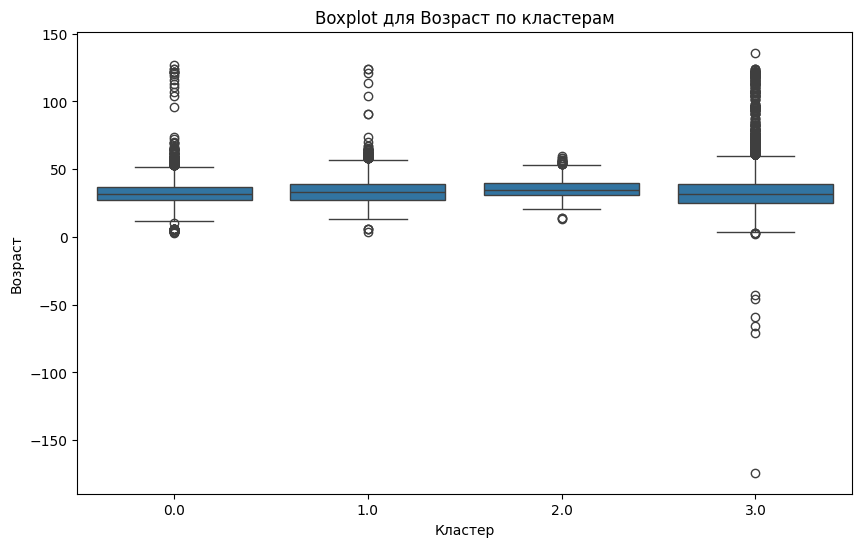

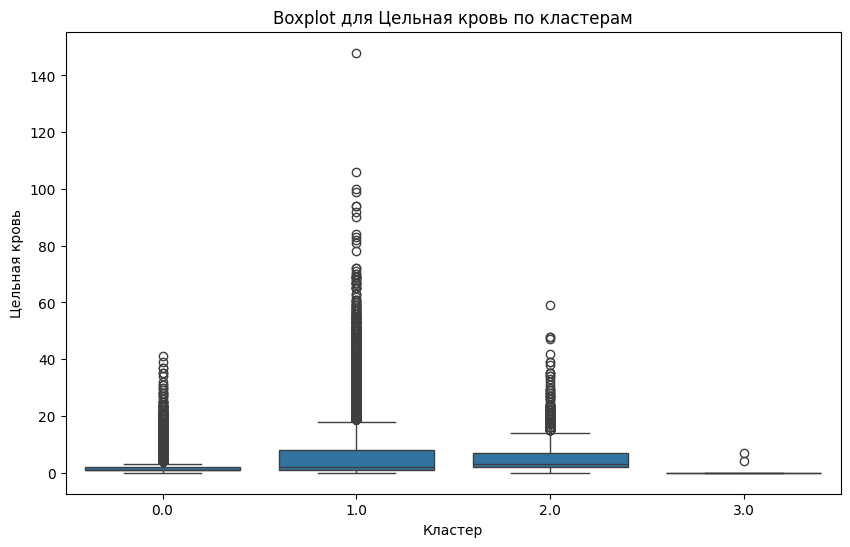

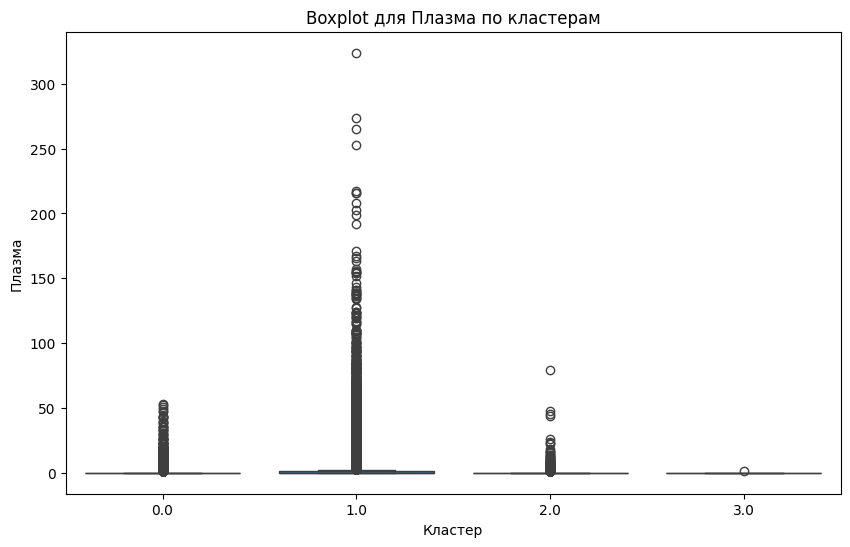

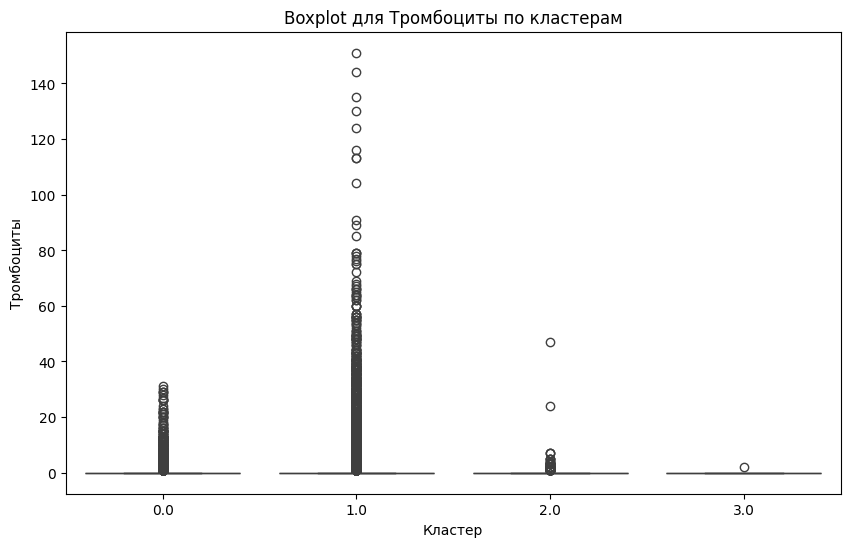

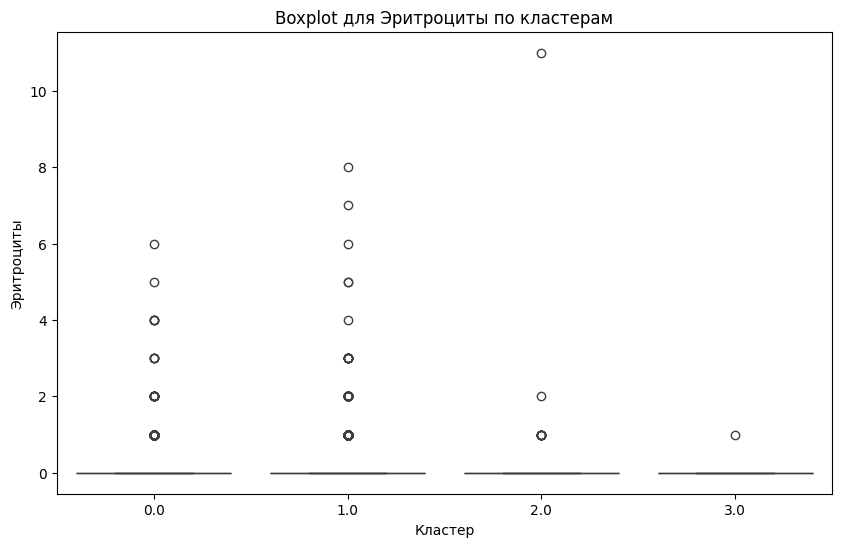

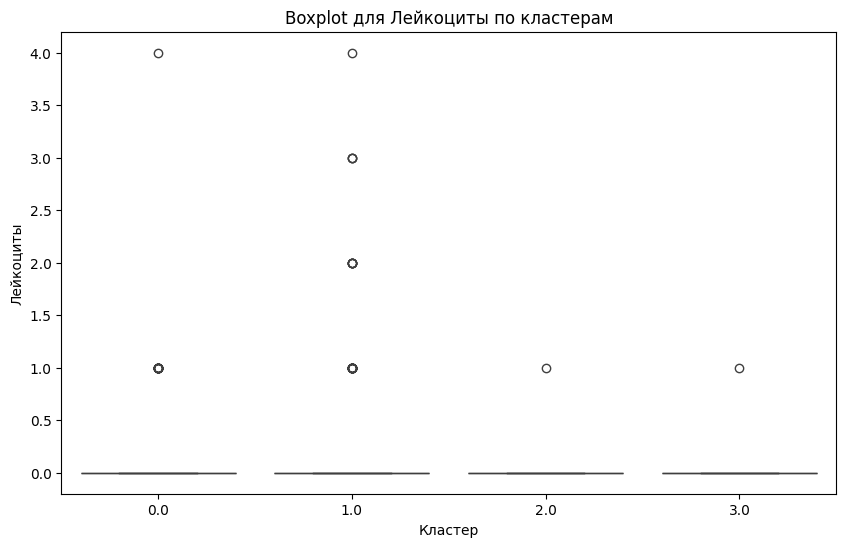

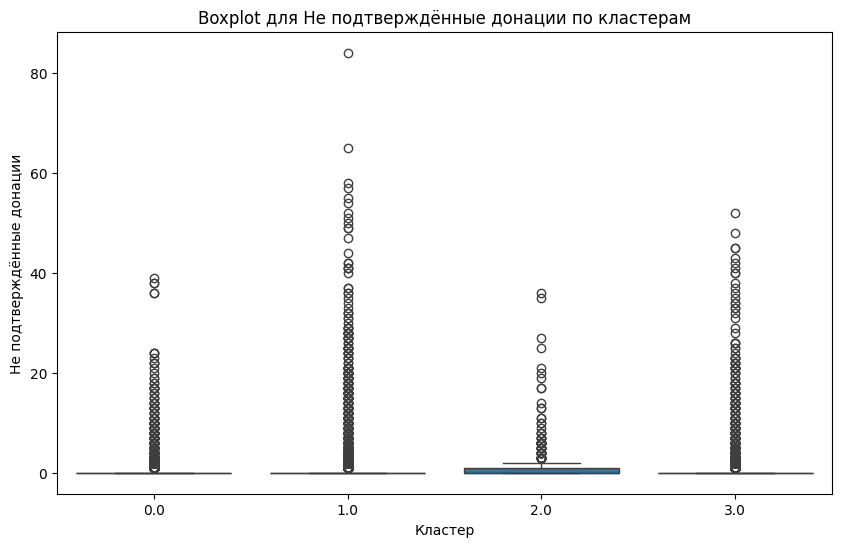

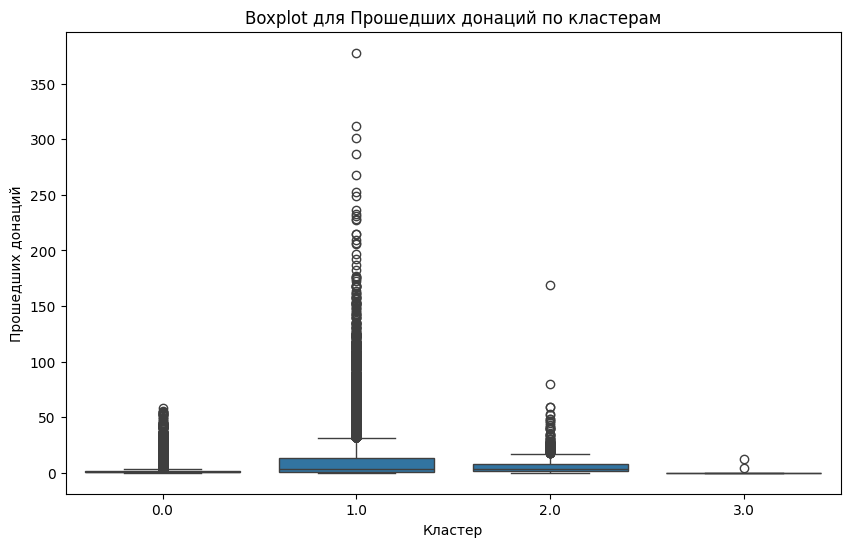

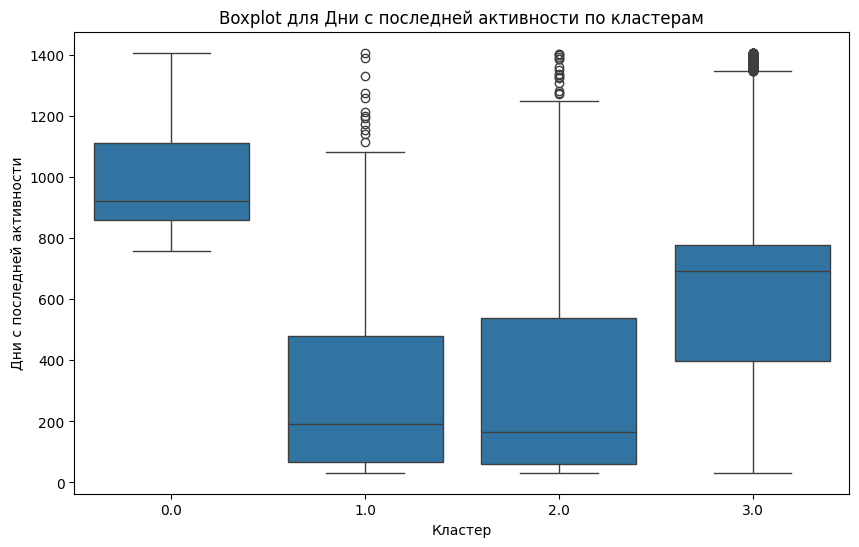

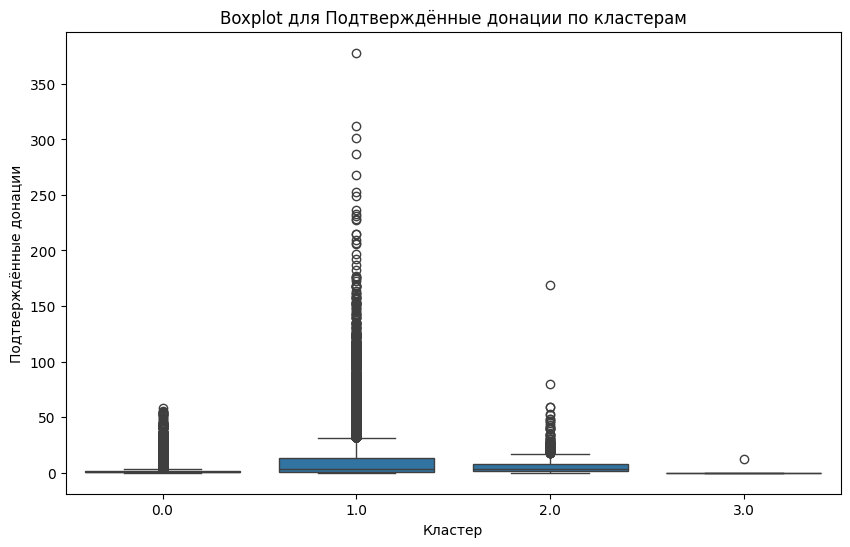

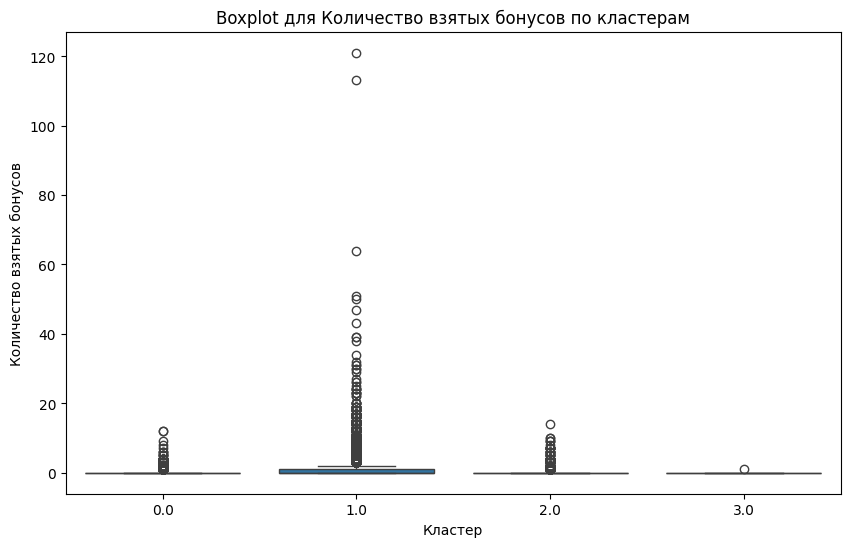


Анализ категориальных колонок:


Пол          Регион Группа крови Kell-фактор  \
Кластер                                                        
0.0      Не указано  Россия, Москва   Не указано  Не указано   
1.0         Мужской  Россия, Москва    A(II) Rh+  Не указано   
2.0         Женский  Россия, Москва   Не указано  Не указано   
3.0      Не указано      Не указано   Не указано  Не указано   

        Готов сдавать Цельную кровь Готов сдавать Плазму  \
Кластер                                                    
0.0                              Да                   Да   
1.0                              Да                   Да   
2.0                              Да                   Да   
3.0                              Да                   Да   

        Готов сдавать Тромбоциты Готов сдавать Эритроциты  \
Кластер                                                     
0.0                           Да                       Да   
1.0                           Да                       Да   
2.0                           Да                       Да   
3.0                           Да                       Да   

        Готов сдавать Лейкоциты Готов сдавать Костный мозг Указан email  \
Кластер                                                                   
0.0                          Да                        Нет           да   
1.0                          Да                        Нет           да   
2.0                          Да                        Нет           да   
3.0                          Да                        Нет           да   

        Указан телефон Авторизация через ВК Авторизация через Одноклассники  \
Кластер                                                                       
0.0                 да                   да                             нет   
1.0                 да                  нет                             нет   
2.0                 да                   да                             нет   
3.0                 да                  нет                             нет   

        Авторизация через Твиттер Авторизация через Яндекс  \
Кластер                                                      
0.0                           нет                      нет   
1.0                           нет                      нет   
2.0                           нет                      нет   
3.0                           нет                      нет   

        Авторизация через Гугл  
Кластер                         
0.0                        нет  
1.0                        нет  
2.0                        нет  
3.0                        нет

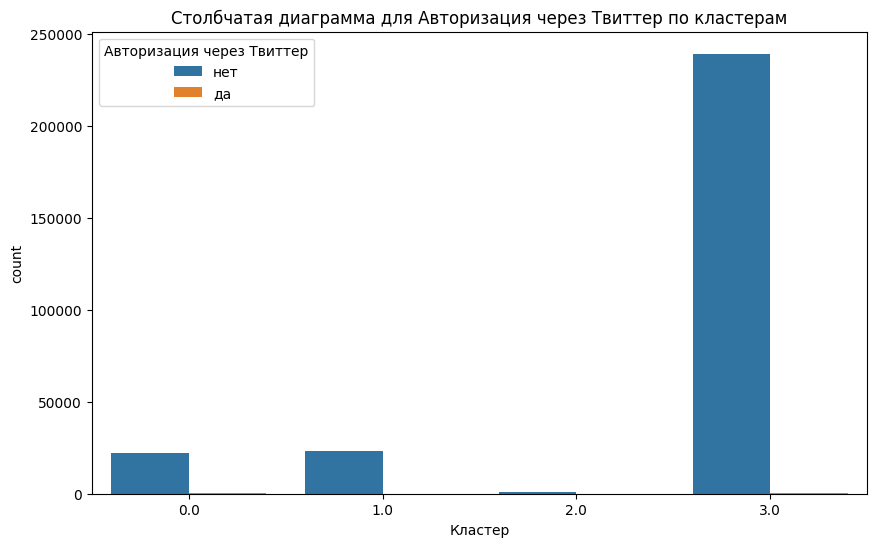

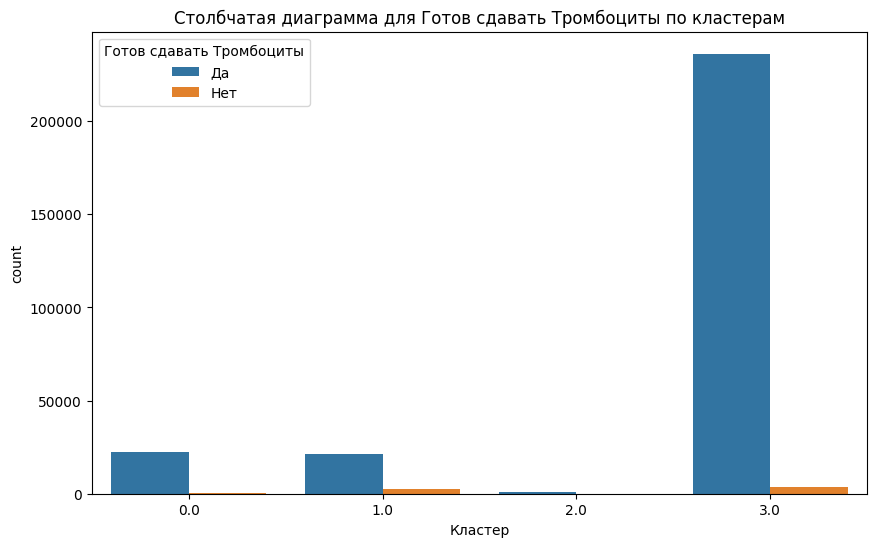

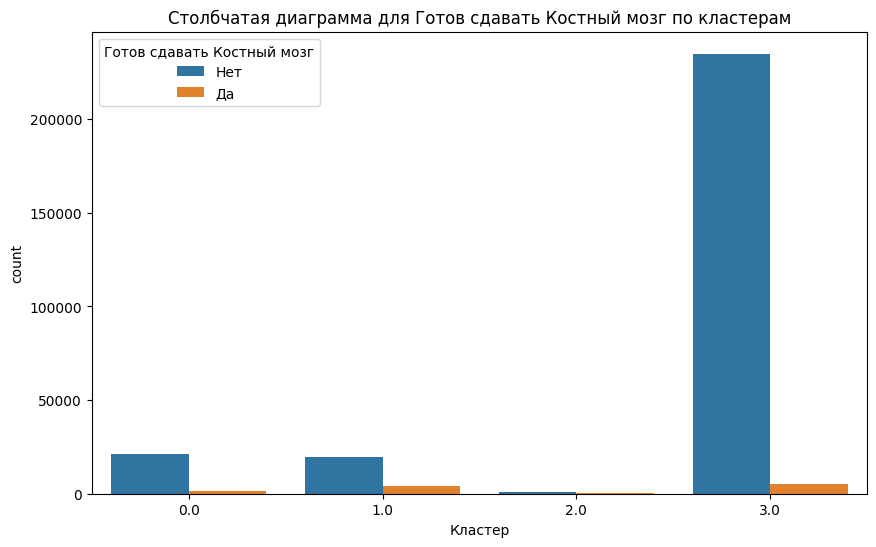

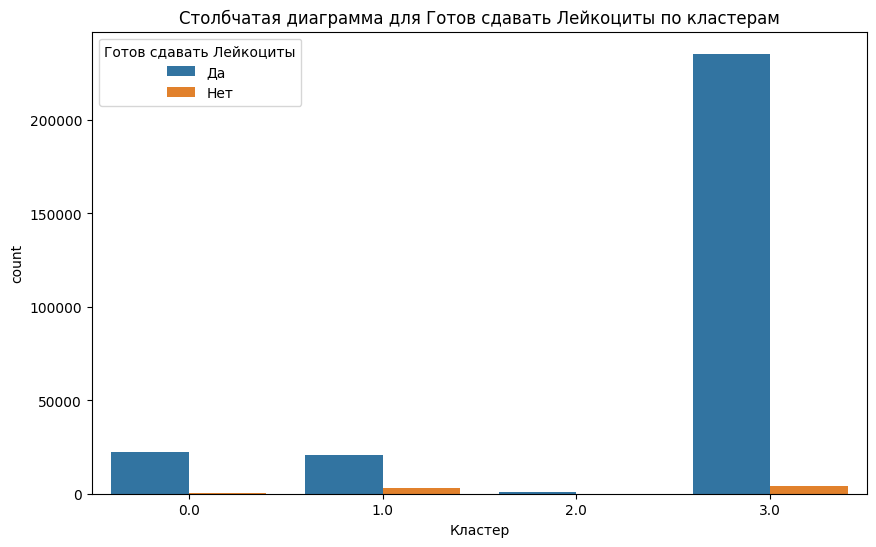

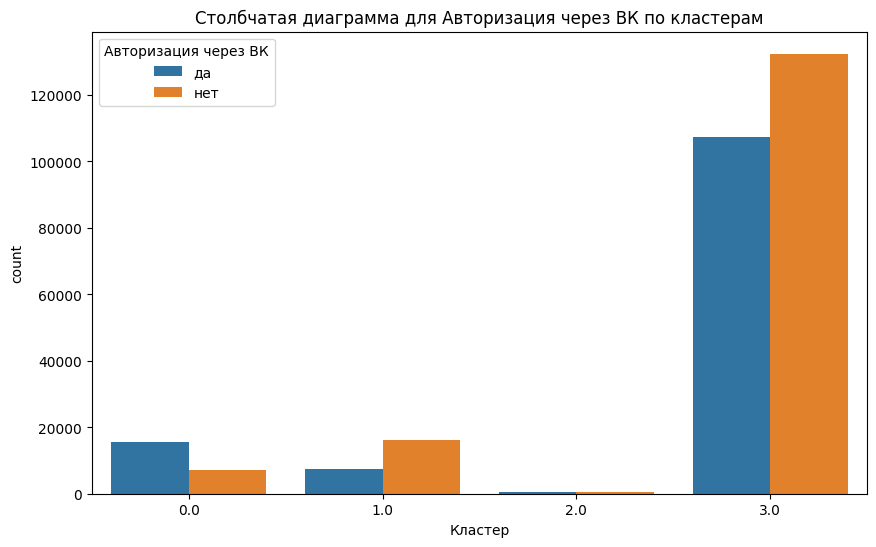

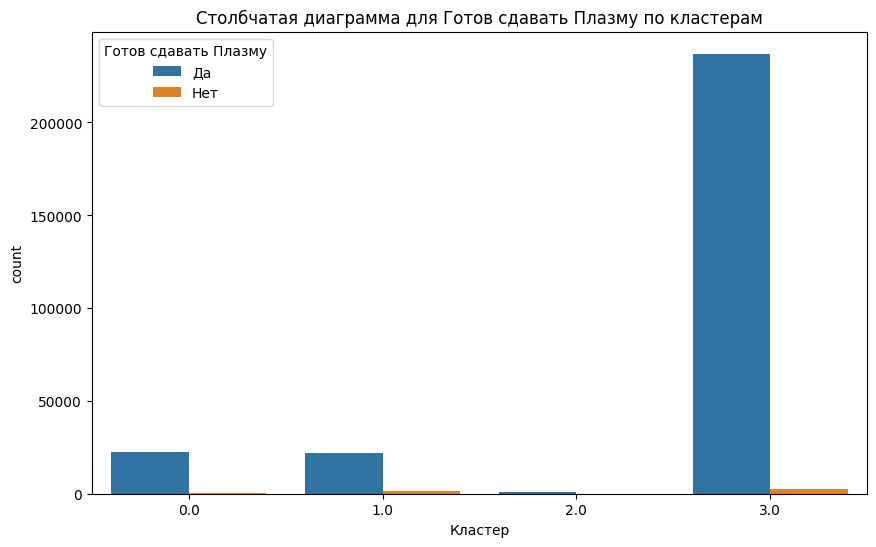

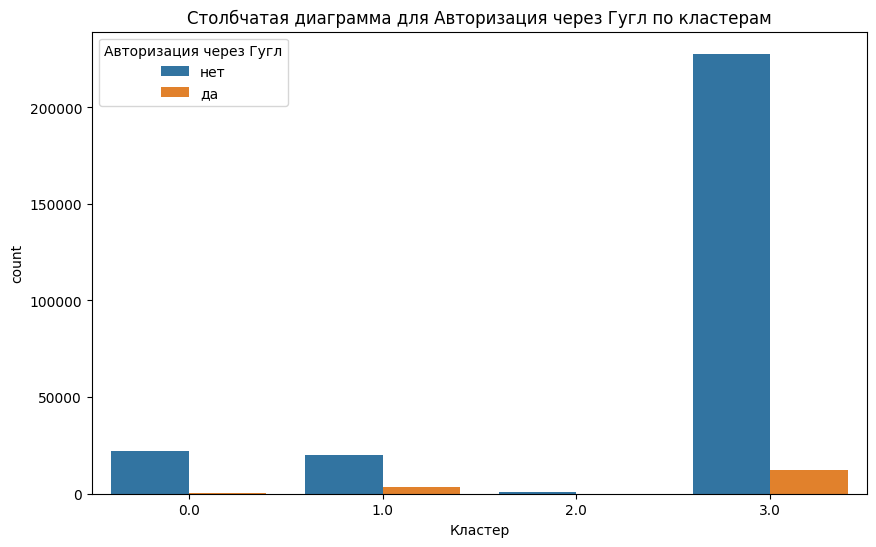

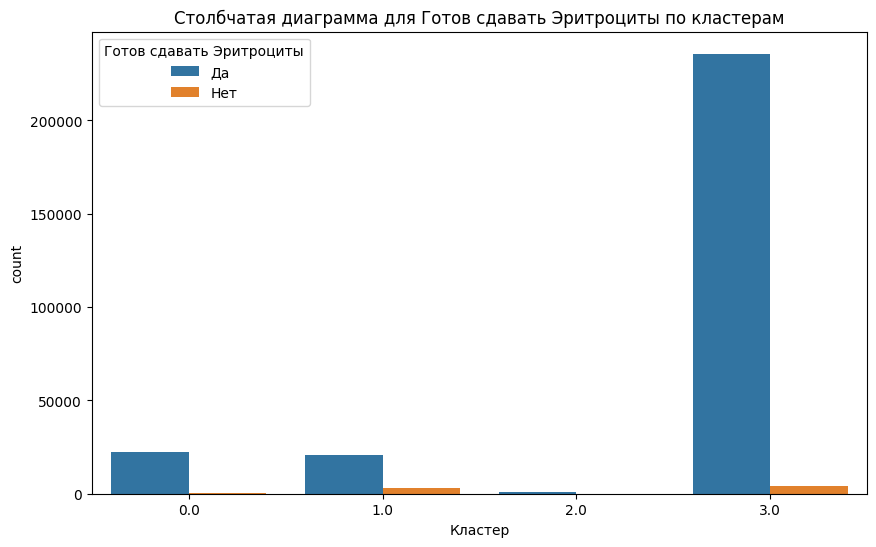

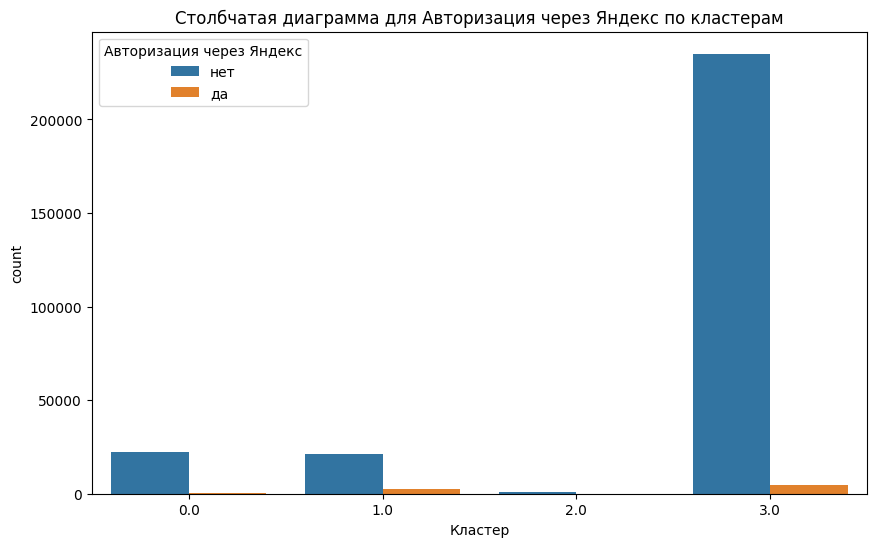

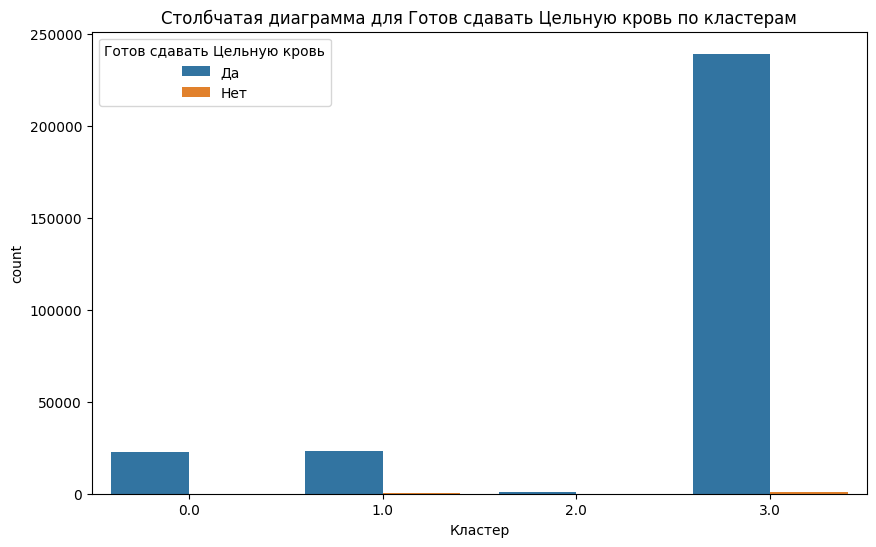

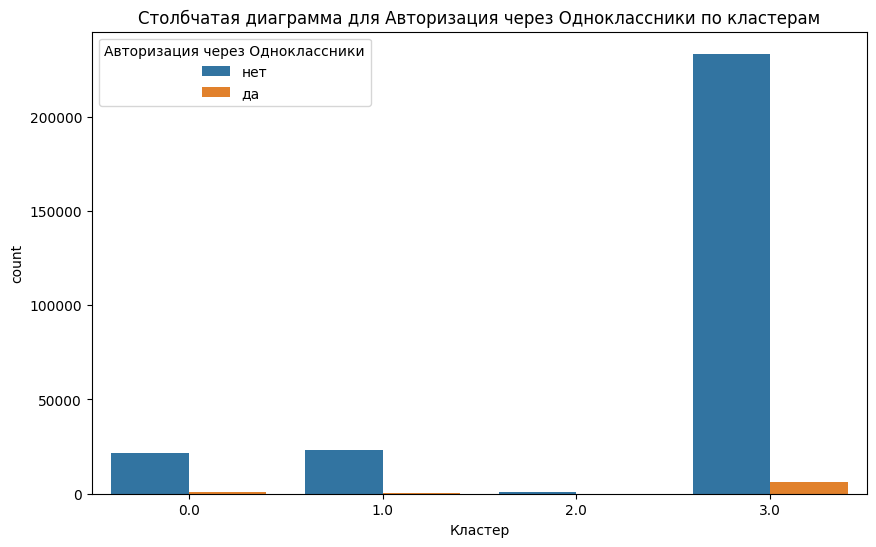

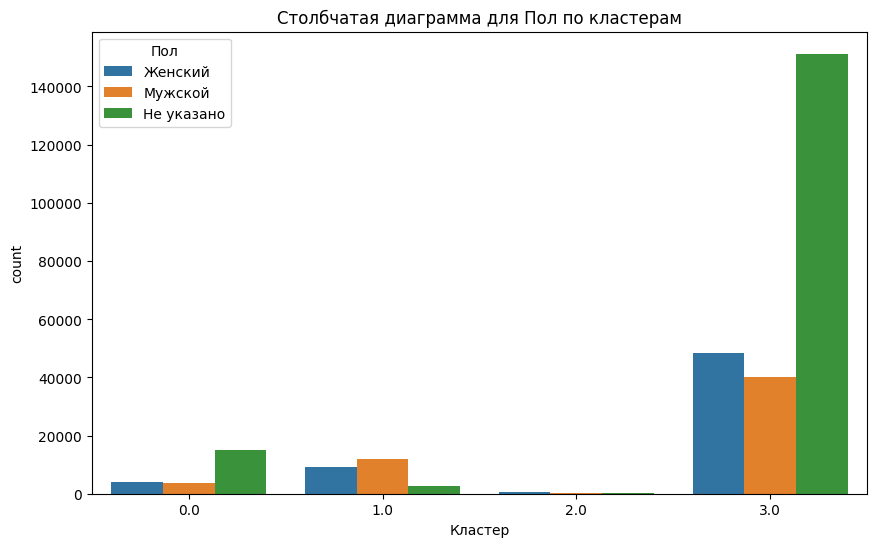

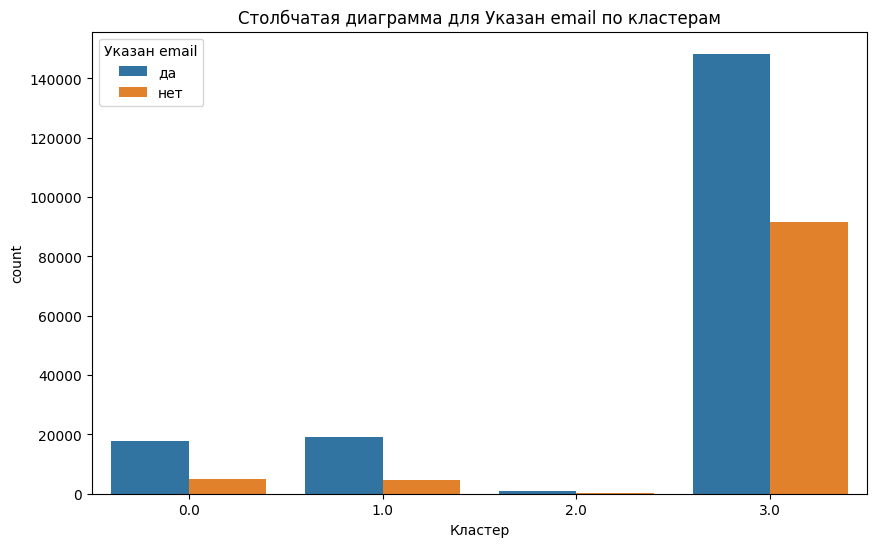

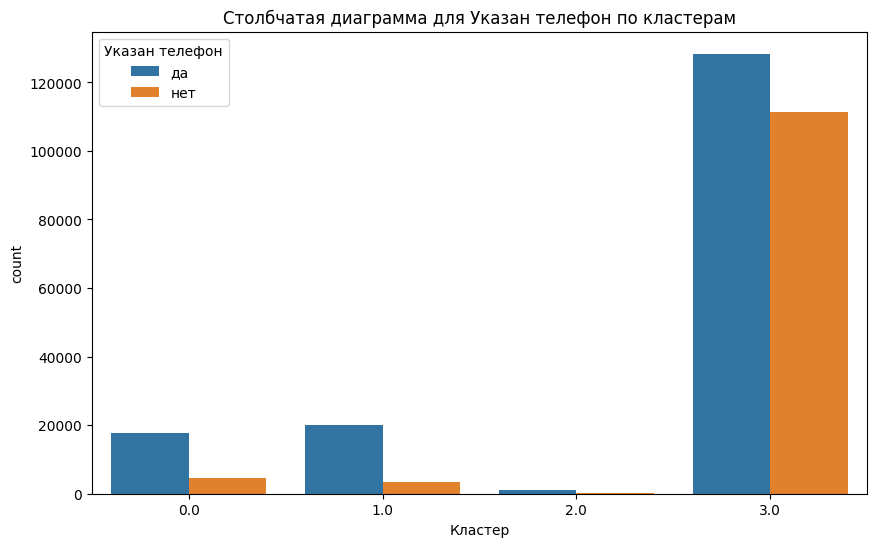

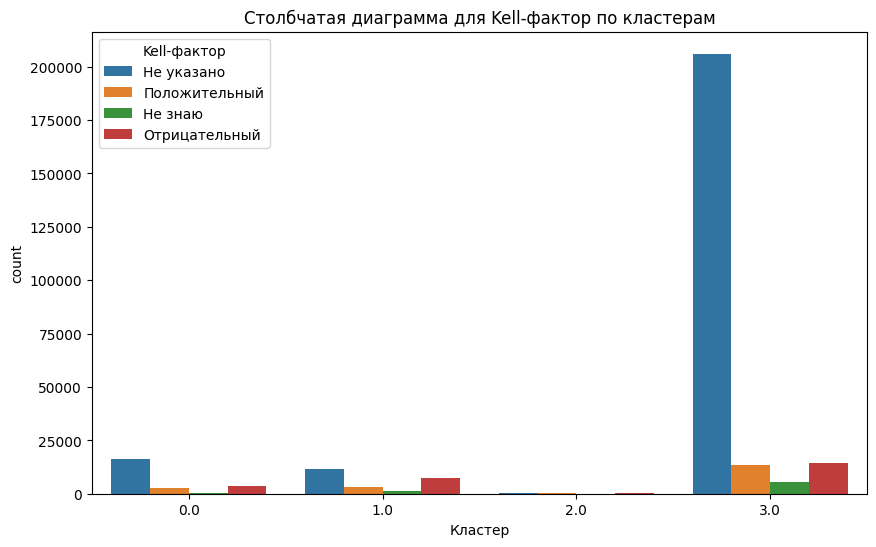

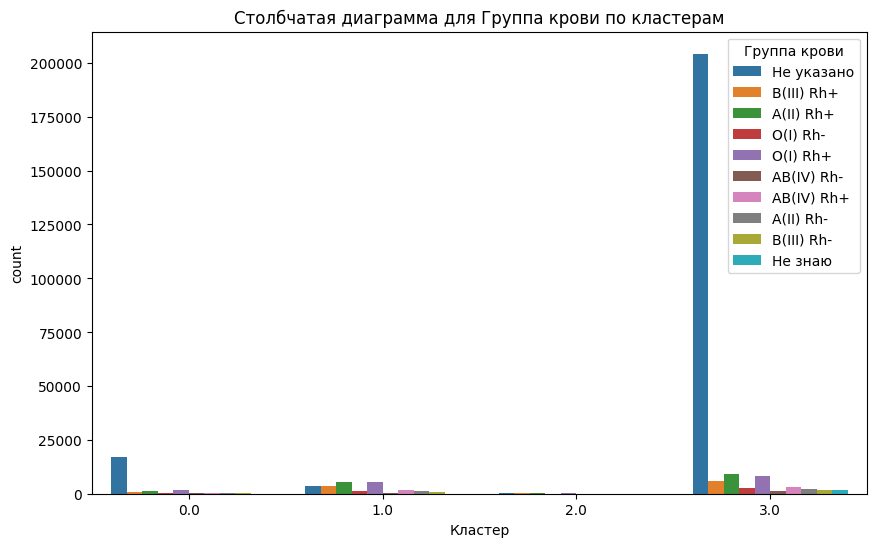

In [9]:
# Анализ числовых колонок
numeric_analysis = user_data.groupby('Кластер')[numeric_columns].describe()

# Анализ категориальных колонок
categorical_analysis = user_data.groupby('Кластер')[categorical_columns].agg(lambda x: x.value_counts().index[0])

# Отображение результатов
print("Анализ числовых колонок:")
display(numeric_analysis)
analyze_numeric_columns(user_data, numeric_columns)
print("\nАнализ категориальных колонок:")
display(categorical_analysis)
analyze_categorical_columns(user_data, categorical_columns)


[Презентация](https://disk.yandex.ru/i/PXxISmPi5zQViA)